This will contain some simple visuals to get insights of the initial data. 

In [2]:
#Importing the necessary libraries
import sys
from pathlib import Path
import subprocess
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import math

import gc

import warnings
warnings.filterwarnings('ignore')

dataPath = '/Users/artjolameli/Desktop/credit_risk_project/machine-learning-dse-i210-final-project-credit-risk/data/raw/parquet_files'

### Checking the size of the dataset
The following cell is used to check the size of each dataframe for both training set and test set. 
- The largest one in training set is *credit_bureau_a_2_5* which takes 2.9G 
- *applprev_1_2, credit_bureau_a_1_4, credit_bureau_a_2_11, static_0_2* are absent in the training set, so these df should not be included while training the model.

In [3]:
def get_disk_usage(directory):
    cmd = f'du {directory}/* -h | sort -rh'
    result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)
    output_lines = result.stdout.split('\n')
    data = [line.split('\t') for line in output_lines if line]
    
    df = pd.DataFrame(data, columns=['size', 'path'])
    df['file_name'] = df.path.str.replace('train_|test_', '', regex=True).apply(lambda x: Path(x).stem)
    return df

train_disk_usage = get_disk_usage(f'{dataPath}/train').reset_index()
test_disk_usage = get_disk_usage(f'{dataPath}/test')

a = train_disk_usage.reset_index().merge(test_disk_usage, on=['file_name'],
                                    how='outer', suffixes=['_train','_test']).sort_values(by='index').drop(columns=['index','path_train','path_test','level_0'])
display(a[:6])
display(a[-5:])

,size_train,file_name,size_test
0,358000,credit_bureau_a_1_1,120
1,241224,credit_bureau_a_1_2,120
2,222384,static_0_0,264
3,208896,applprev_1_0,64
4,145888,static_0_1,264
5,142312,applprev_1_1,64


,size_train,file_name,size_test
31,1576,other_1,16
32,NaN,static_0_2,256
33,NaN,credit_bureau_a_1_4,120
34,NaN,applprev_1_2,64
35,NaN,credit_bureau_a_2_11,32


In [4]:
path_train_base = f'{dataPath}/train/train_base.parquet'
path_test_base = f'{dataPath}/test/test_base.parquet'

train_base = pd.read_parquet(path_train_base)
test_base = pd.read_parquet(path_test_base)

print(train_base.shape)
print(test_base.shape)

(1526659, 5)
(10, 4)


#### Transform the 'MONTH' features into 'year' and 'month' feature

In [5]:
train_base['year'] = train_base['MONTH'] // 100
train_base['month'] = train_base['MONTH'] % 100
train_base = train_base.drop(columns=['MONTH'])
display(train_base.head(5))

,case_id,date_decision,WEEK_NUM,target,year,month
0,0,2019-01-03,0,0,2019,1
1,1,2019-01-03,0,0,2019,1
2,2,2019-01-04,0,0,2019,1
3,3,2019-01-03,0,0,2019,1
4,4,2019-01-04,0,1,2019,1


In [6]:
def get_date_interval_info(df):
    df['date_decision'] = pd.to_datetime(df['date_decision'])
    date_delta = df['date_decision'].drop_duplicates().sort_values().diff()
    len_uniq_dates = len(df.date_decision.unique())
    print(
        f'\n Actual date range:  {date_delta.sum().days + 1} day(s).',
        f'\n Total unique dates: {len_uniq_dates} day(s).'
    )

    print(f'\n Min date: {df.date_decision.dt.date.min()}',
          f'\n Max date: {df.date_decision.dt.date.max()}')
    
get_date_interval_info(train_base)


 Actual date range:  644 day(s). 
 Total unique dates: 644 day(s).

 Min date: 2019-01-01 
 Max date: 2020-10-05


#### Target
Target is defined as whether or not the client defaulted on the specific credit case.
As we can see are are dealing with a highly imbalanced dataset

([<matplotlib.patches.Wedge at 0x7f84e5241820>,
 [Text(-1.0946395745925022, 0.1084629048843239, '0'),
  Text(1.0946395733231236, -0.10846291769526761, '1')],
 [Text(-0.5970761315959102, 0.05916158448235849, '96.9%'),
  Text(0.5970761309035219, -0.05916159147014596, '3.1%')])

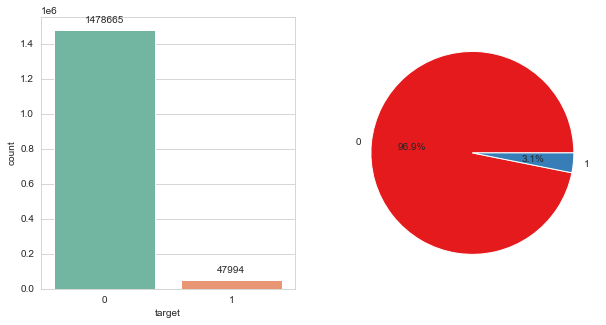

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(data=train_base, x='target', palette="Set2")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.subplot(1,2,2)
plt.pie(train_base['target'].value_counts(), labels=['0','1'], autopct='%1.1f%%', colors=sns.color_palette("Set1"))

(0.0, 10000.0)

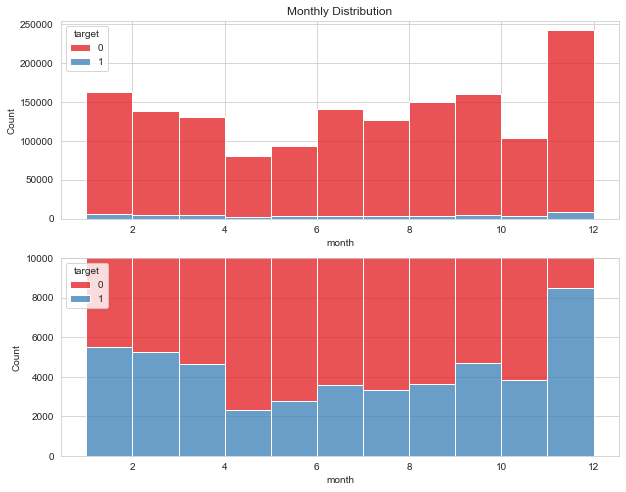

In [8]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.histplot(data=train_base, x='month', hue="target", binwidth=1, multiple="stack", palette="Set1")
plt.title("Monthly Distribution")

plt.subplot(2,1,2)
sns.histplot(data=train_base, x='month', hue="target", binwidth=1, multiple="stack", palette="Set1")
plt.ylim(0,10000)

(0.0, 2000.0)

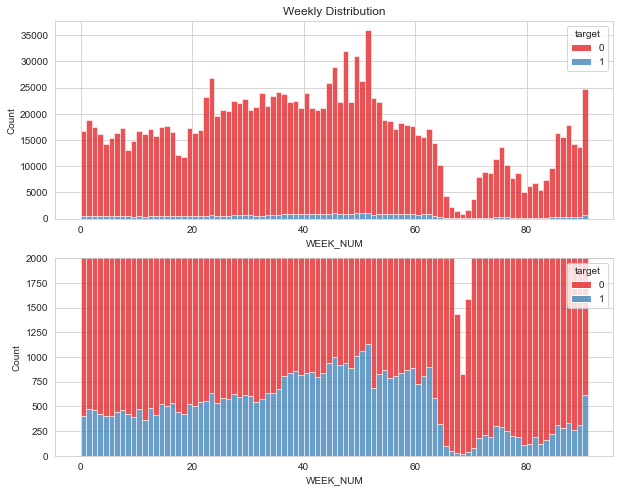

In [16]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.histplot(data=train_base, x='WEEK_NUM', hue="target", binwidth=1, multiple="stack", palette="Set1")
plt.title("Weekly Distribution")

plt.subplot(2,1,2)
sns.histplot(data=train_base, x='WEEK_NUM', hue="target", binwidth=1, multiple="stack", palette="Set1")
plt.ylim(0,2000)

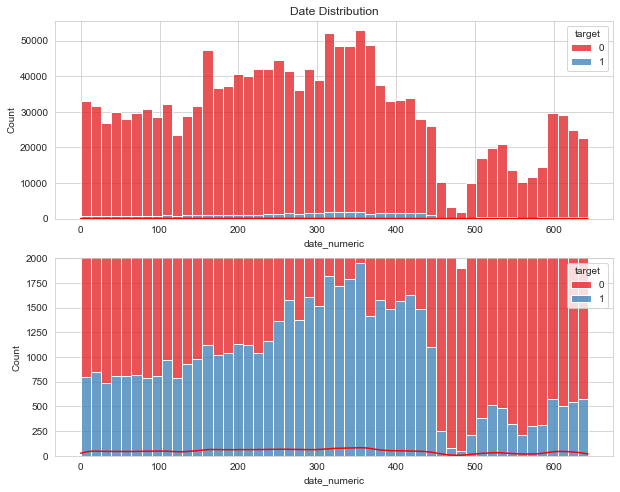

In [18]:
# Convert 'date_decision' to 'date_numeric' if 'date_decision' is your original date column
if 'date_decision' in train_base.columns:
    train_base['date_numeric'] = (train_base['date_decision'] - train_base['date_decision'].min()).dt.days
else:
    print("date_decision column is missing")
    
kde = gaussian_kde(train_base['date_numeric'].dropna())  # Ensure no NaN values
x_range = np.linspace(train_base['date_numeric'].min(), train_base['date_numeric'].max(), 1000)
kde_values = kde(x_range)

# Plot histograms and the manually calculated KDE on the same plots
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.histplot(data=train_base, x='date_numeric', hue="target", bins=50, multiple="stack", palette="Set1")
plt.plot(x_range, kde_values * train_base.shape[0] / 50, color='red')  # Adjust scaling as necessary
plt.title("Date Distribution")

plt.subplot(2,1,2)
sns.histplot(data=train_base, x='date_numeric', hue="target", bins=50, multiple="stack", palette="Set1")
plt.plot(x_range, kde_values * train_base.shape[0] / 50, color='red')  # Maintain consistency in scaling
plt.ylim(0, 2000)

plt.show()